In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Load the CSV data and convert to images

In [17]:
df = pd.read_csv('data/fer2013/fer2013/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


<Axes: xlabel='emotion'>

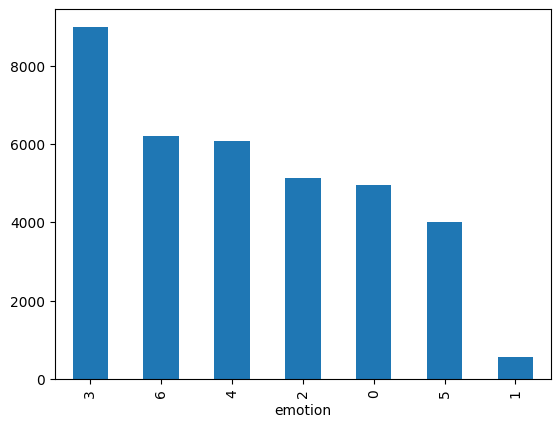

In [18]:
df.emotion.value_counts()
df.Usage.value_counts()
df.emotion.value_counts().plot(kind='bar')

In [19]:
np.sqrt(len(df.pixels[0].split(' ')))

48.0

In [20]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [32]:
label_array = df.emotion.values
label_array

array([0, 0, 2, ..., 0, 3, 2])

In [21]:
img_array.shape

(35887, 48, 48)

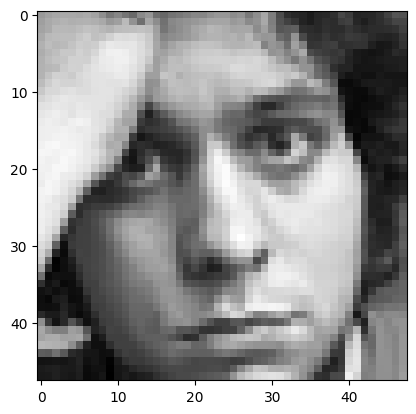

In [26]:
plt.imshow(img_array[500], cmap='gray')
plt.show()

# Create a dataloader with some augmentations

In [90]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image pixels
])

In [91]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [92]:
# Assuming you have your images in an array called 'image_array' and labels in 'label_array'
pil_images = [Image.fromarray(image).convert('RGB') for image in img_array]
dataset = CustomDataset(pil_images, label_array, transform=image_transforms)

# Create a DataLoader instance to load the dataset
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [93]:
# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust color jitter
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image pixels
])

# Apply the augmentation transformations to the dataset
pil_images = [Image.fromarray(image).convert('RGB') for image in img_array]
augmented_dataset = CustomDataset(pil_images, label_array, transform=augmentation_transforms)

# Create a DataLoader instance for the augmented dataset
augmented_data_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

In [94]:
len(augmented_dataset)

35887

In [95]:
# Determine the size of the training and testing sets
dataset_size = len(augmented_data_loader.dataset)
train_size = int(0.8 * dataset_size)  # 80% for training, adjust as needed
test_size = dataset_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(augmented_data_loader.dataset, [train_size, test_size])

# Create separate DataLoaders for training and testing
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

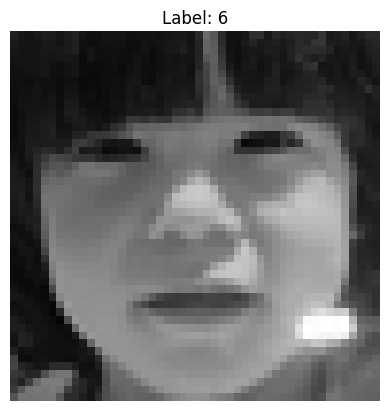

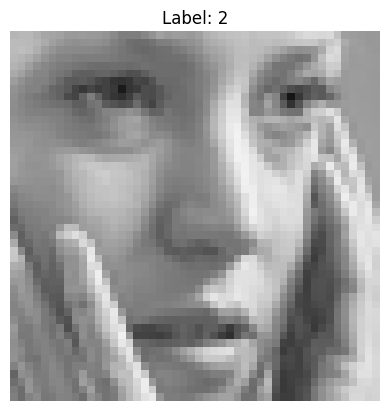

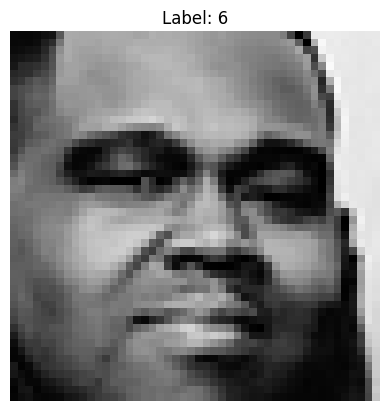

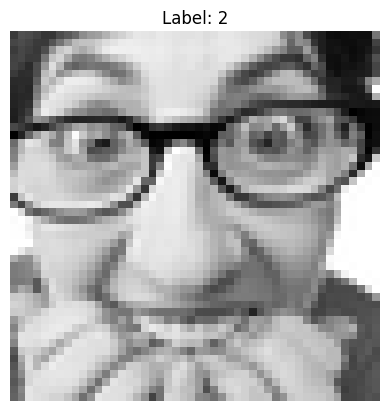

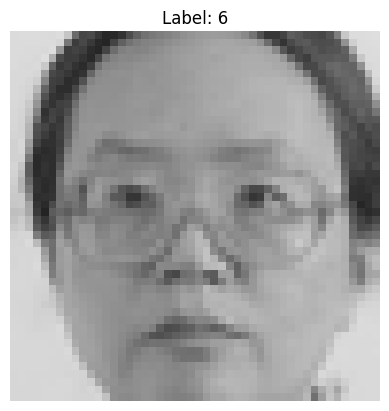

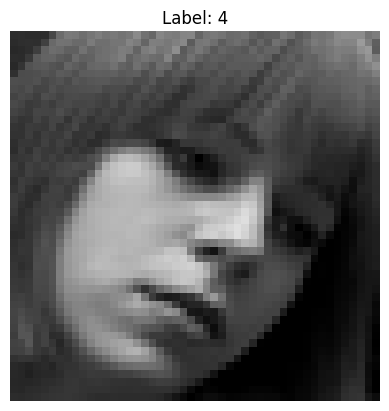

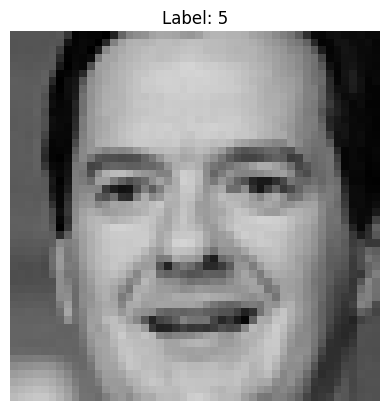

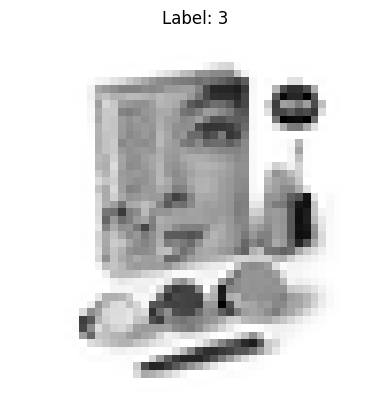

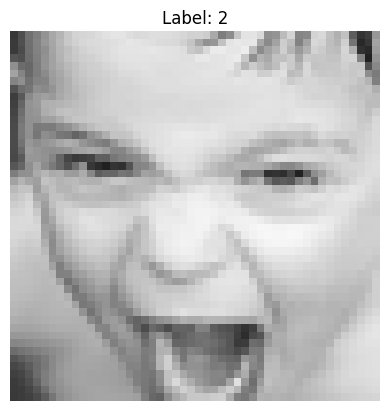

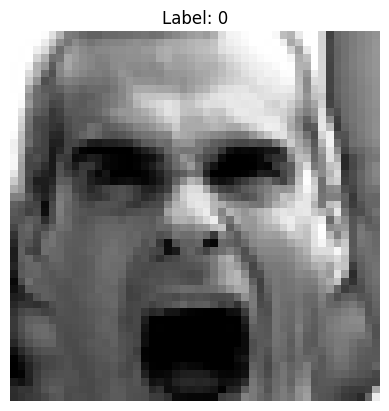

In [96]:
# Iterate over the data loader
for images, labels in data_loader:
    # Convert the images to NumPy arrays
    images_np = images.numpy()

    # Denormalize the images (if normalization was applied)
    images_np = (images_np * 0.5) + 0.5

    # Convert the labels to a list
    labels_list = labels.tolist()

    # Visualize the images
    num_images = 10
    for i in range(num_images):
        image_np = np.transpose(images_np[i], (1, 2, 0))  # Transpose to (H, W, C) format
        # image_np = images[i]

        # Get the corresponding label
        label = labels_list[i]

        # Plot the image and display the label
        plt.imshow(image_np, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

    # Break the loop after viewing one batch of images
    break

# Create the CNN

In [97]:
class EmoCNN(nn.Module):
    def __init__(self):
        super(EmoCNN, self).__init__()
        # Add more layers as per your desired architecture
        self.layer1 = nn.Sequential( # input shape (1, 48, 48)
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # (16, 48, 48)
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (32, 48, 48)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (32, 24, 24)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (64, 24, 24)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (64, 12, 12)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 12, 12)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # (128, 12, 12)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc = nn.Linear(128 * 12 * 12, 7) # 7 classes

    def forward(self, x):
        x = self.layer1(x) # (16, 48, 48)
        x = self.layer2(x) # (32, 24, 24)
        x = self.layer3(x) # (64, 12, 12)
        x = self.layer4(x) # (128, 12, 12)
        x = self.layer5(x) # (128, 12, 12)
        x = x.reshape(x.size(0), -1) # (128 * 12 * 12)
        x = self.fc(x)
        return x

In [100]:
# Create an instance of the model class
model = EmoCNN()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs to train for
n_epochs = 30

# Move the model to the GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "mps"
print(device)
model = model.to(device)

best_epoch = 0
lowest_loss = np.Inf
# Iterate over epochs
for epoch in range(n_epochs):
    model.train()  # Set model to training mode

    print(f"Epoch: {epoch + 1}/{n_epochs} ", end="")

    # Iterate over the dataset
    for images, labels in train_data_loader:
        # print progress of training
        # print(f"Epoch: {epoch + 1}/{n_epochs}... ", end="")
        # print("Loss: {:.4f}".format(loss.item()))

        optimizer.zero_grad()  # Zero out gradients
        output = model(images.to(device))  # Forward pass
        loss = criterion(output, labels.to(device))  # Compute loss
        loss.backward()  # Perform backward pass
        optimizer.step()  # Update weights
    
    print("Loss: {:.4f}".format(loss.item()))
    if loss.item() < lowest_loss:
        lowest_loss = loss.item()
        torch.save(model.state_dict(), 'model.pt')
        best_epoch = epoch + 1

print(f"Best epoch: {best_epoch} with loss: {lowest_loss}")

mps
Epoch: 1/30... Loss: 1.4318
Epoch: 2/30... Loss: 0.9098
Epoch: 3/30... Loss: 1.1185
Epoch: 4/30... Loss: 1.0841
Epoch: 5/30... Loss: 1.2798
Epoch: 6/30... Loss: 1.2698
Epoch: 7/30... Loss: 0.9252
Epoch: 8/30... Loss: 0.2218
Epoch: 9/30... Loss: 0.9487
Epoch: 10/30... Loss: 0.2189
Epoch: 11/30... Loss: 0.0126
Epoch: 12/30... Loss: 1.3806
Epoch: 13/30... Loss: 0.0139
Epoch: 14/30... Loss: 0.0990
Epoch: 15/30... Loss: 0.0017
Epoch: 16/30... Loss: 0.1601
Epoch: 17/30... Loss: 0.0015
Epoch: 18/30... Loss: 0.0537
Epoch: 19/30... Loss: 0.1886
Epoch: 20/30... Loss: 0.0041
Epoch: 21/30... Loss: 0.0076
Epoch: 22/30... Loss: 0.0117
Epoch: 23/30... Loss: 0.0021
Epoch: 24/30... Loss: 1.4381
Epoch: 25/30... Loss: 0.0009
Epoch: 26/30... Loss: 0.0019
Epoch: 27/30... Loss: 0.0429
Epoch: 28/30... Loss: 0.0051
Epoch: 29/30... Loss: 0.0360
Epoch: 30/30... Loss: 0.0080


In [105]:
device = "mps"
model = EmoCNN()
state_dict = torch.load('model.pt')
model.load_state_dict(state_dict)
model = model.to(device)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_data_loader:
        labels = labels.to(device)
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy}%")

Test Accuracy = 58.331011423794926%


In [64]:
torch.save(model.state_dict(), 'best.pth')